C:\Users\Dell\AppData\Local\Temp\ipykernel_30580\1880192587.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  "time": pd.date_range(start="2024-01-01", periods=100, freq="S"),
C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


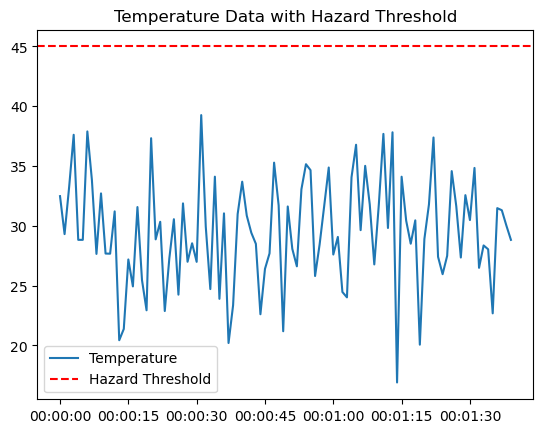

                 time  temperature  gas_concentration  priority
0 2024-01-01 00:00:00    32.483571          35.846293         1
1 2024-01-01 00:00:01    29.308678          45.793547         1
2 2024-01-01 00:00:02    33.238443          46.572855         1
3 2024-01-01 00:00:03    37.615149          41.977227         1
4 2024-01-01 00:00:04    28.829233          48.387143         1


In [9]:
# Import Libraries
import numpy as np
import pandas as pd
import cv2  # For Optical Flow
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Step 1: Simulate Sensor Data (Temperature, Gas, Motion)
def simulate_sensor_data():
    np.random.seed(42)
    data = pd.DataFrame({
        "time": pd.date_range(start="2024-01-01", periods=100, freq="S"),
        "temperature": np.random.normal(loc=30, scale=5, size=100),
        "gas_concentration": np.random.normal(loc=50, scale=10, size=100),
        "motion_x": np.random.normal(0, 1, size=100),
        "motion_y": np.random.normal(0, 1, size=100),
    })
    return data

sensor_data = simulate_sensor_data()

# Step 2: Feature Engineering (Gradients, Patterns)
sensor_data["temp_gradient"] = sensor_data["temperature"].diff().fillna(0)
sensor_data["motion_magnitude"] = np.sqrt(sensor_data["motion_x"]**2 + sensor_data["motion_y"]**2)

# Step 3: Train Random Forest Classifier for Gas & Overheating
X_rf = sensor_data[["temperature", "temp_gradient", "gas_concentration"]]
y_rf = (sensor_data["temperature"] > 45) | (sensor_data["gas_concentration"] > 70)  # Hazard labels
rf_model = RandomForestClassifier()
rf_model.fit(X_rf, y_rf)

# Step 4: Train CNN for Fire Detection (Simulated Training)
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Simulated data - Assume we have preprocessed fire images
cnn_model = create_cnn_model()
# cnn_model.fit(fire_images, fire_labels, epochs=10, batch_size=32)

# Step 5: Optical Flow for Motion Detection
def calculate_optical_flow(frame1, frame2):
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return np.linalg.norm(flow, axis=2).mean()

# Simulated frame data
frame1 = np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8)
frame2 = np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8)
motion_magnitude = calculate_optical_flow(frame1, frame2)

# Step 6: Real-Time Detection Logic
def prioritize_qos(sensor_data):
    sensor_data["priority"] = sensor_data.apply(
        lambda row: 3 if row["temperature"] > 45 or row["gas_concentration"] > 70 else
                    2 if row["motion_magnitude"] > 1.5 else 1,
        axis=1
    )
    return sensor_data

prioritized_data = prioritize_qos(sensor_data)

# Step 7: Visualization of Results
plt.plot(sensor_data["time"], sensor_data["temperature"], label="Temperature")
plt.axhline(y=45, color="r", linestyle="--", label="Hazard Threshold")
plt.legend()
plt.title("Temperature Data with Hazard Threshold")
plt.show()

# Example QoS Prioritization Table
print(prioritized_data[["time", "temperature", "gas_concentration", "priority"]].head())


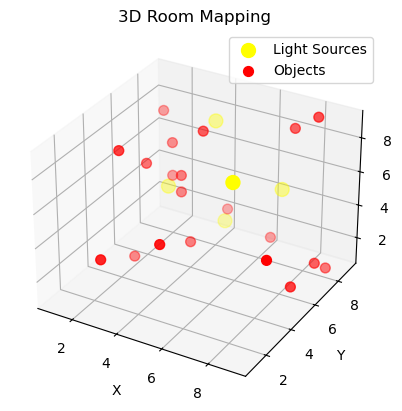

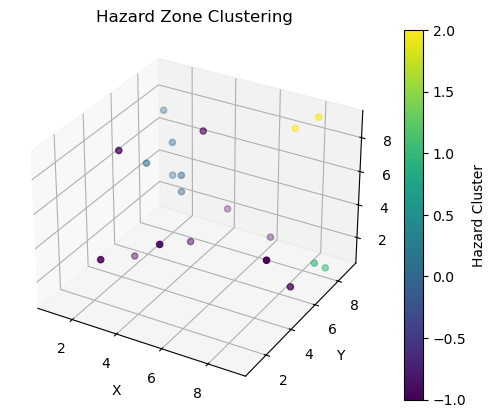

Updated Hazard Labels: [-1 -1 -1  0 -1  0  1 -1 -1 -1 -1  0  0 -1 -1  2 -1  2 -1  1]


In [11]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
import time

# Step 1: Simulate a 3D Room Mapping with Ray Tracing
def generate_3d_room():
    np.random.seed(42)
    room_dimensions = (10, 10, 10)  # Room dimensions in meters
    light_sources = np.random.randint(1, 10, size=(5, 3))  # Random positions of 5 light sources
    objects = np.random.randint(1, 10, size=(20, 3))  # Random object positions
    return room_dimensions, light_sources, objects

room, lights, objects = generate_3d_room()

# Plot 3D Room with Lights and Objects
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lights[:, 0], lights[:, 1], lights[:, 2], color='yellow', label='Light Sources', s=100)
ax.scatter(objects[:, 0], objects[:, 1], objects[:, 2], color='red', label='Objects', s=50)
ax.set_title("3D Room Mapping")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend()
plt.show()

# Step 2: Simulate Light Behavior Using Monte Carlo
def monte_carlo_light_simulation(lights, objects, room):
    light_intensity = []
    for obj in objects:
        intensity = 0
        for light in lights:
            distance = np.linalg.norm(light - obj)  # Euclidean distance
            intensity += 1 / (distance ** 2 + 1e-6)  # Inverse-square law for light intensity
        light_intensity.append(intensity)
    return np.array(light_intensity)

light_intensities = monte_carlo_light_simulation(lights, objects, room)

# Step 3: Hazard Zone Detection Using DBSCAN
def detect_hazard_zones(objects, light_intensities, threshold=0.2):
    hazard_data = np.column_stack((objects, light_intensities))
    clustering = DBSCAN(eps=2, min_samples=2).fit(hazard_data)
    return clustering.labels_

hazard_labels = detect_hazard_zones(objects, light_intensities)

# Visualize Hazard Zones
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(objects[:, 0], objects[:, 1], objects[:, 2], c=hazard_labels, cmap='viridis')
ax.set_title("Hazard Zone Clustering")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.colorbar(scatter, ax=ax, label='Hazard Cluster')
plt.show()

# Step 4: Dynamic Mapping Updates with SLAM (Simulation)
# Example: Dynamic update by moving one object
objects[0] += [1, 1, 1]  # Simulating object movement
light_intensities_updated = monte_carlo_light_simulation(lights, objects, room)
hazard_labels_updated = detect_hazard_zones(objects, light_intensities_updated)

print("Updated Hazard Labels:", hazard_labels_updated)


C:\Users\Dell\AppData\Local\Temp\ipykernel_30580\1058198390.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "time": pd.date_range(start="2024-01-01", periods=500, freq="H"),


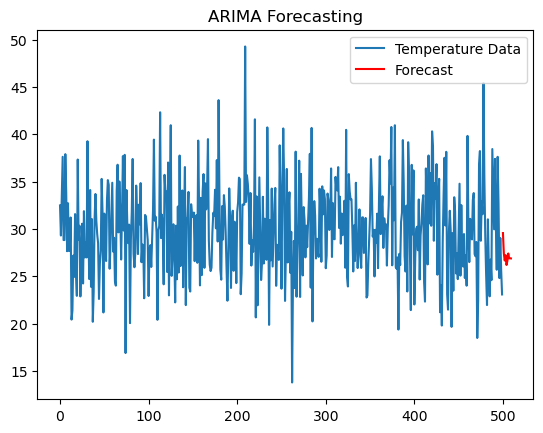

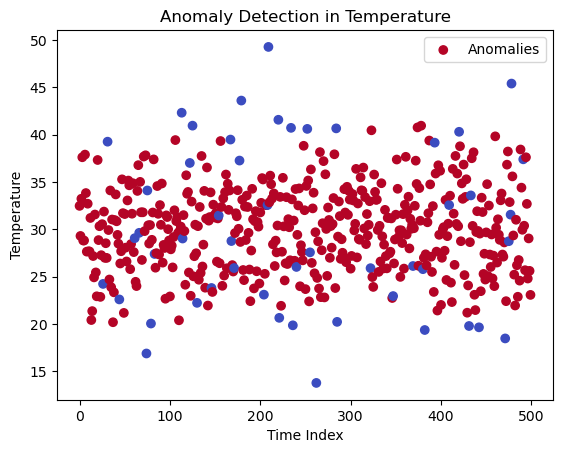

In [13]:
# Import libraries
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Simulate Historical Data
def generate_historical_data():
    np.random.seed(42)
    data = {
        "time": pd.date_range(start="2024-01-01", periods=500, freq="H"),
        "temperature": np.random.normal(30, 5, 500),
        "gas_level": np.random.normal(50, 10, 500),
    }
    return pd.DataFrame(data)

historical_data = generate_historical_data()

# Step 2: Time-Series Forecasting with ARIMA
def arima_forecast(data, steps=10):
    model = ARIMA(data, order=(5, 1, 0))  # ARIMA(p,d,q)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

temperature_forecast = arima_forecast(historical_data["temperature"])

plt.plot(historical_data["temperature"], label="Temperature Data")
plt.plot(range(len(historical_data), len(historical_data) + len(temperature_forecast)),
         temperature_forecast, label="Forecast", color="red")
plt.legend()
plt.title("ARIMA Forecasting")
plt.show()

# Step 3: Anomaly Detection with Isolation Forest
def detect_anomalies(data):
    model = IsolationForest(contamination=0.1)
    data["anomaly"] = model.fit_predict(data[["temperature", "gas_level"]])
    return data

anomalies_detected = detect_anomalies(historical_data)

# Visualize Anomalies
plt.scatter(historical_data.index, historical_data["temperature"], 
            c=anomalies_detected["anomaly"], cmap="coolwarm", label="Anomalies")
plt.title("Anomaly Detection in Temperature")
plt.xlabel("Time Index")
plt.ylabel("Temperature")
plt.legend()
plt.show()

# Step 4: Predictive Maintenance with XGBoost (Simulated Data)
from xgboost import XGBClassifier
def predictive_maintenance(data):
    np.random.seed(42)
    # Simulated failure data
    data["failure"] = (data["temperature"] > 45) | (data["gas_level"] > 70)
    X = data[["temperature", "gas_level"]]
    y = data["failure"]
    model = XGBClassifier()
    model.fit(X, y)
    return model

maintenance_model = predictive_maintenance(historical_data)


<Figure size 640x480 with 0 Axes>

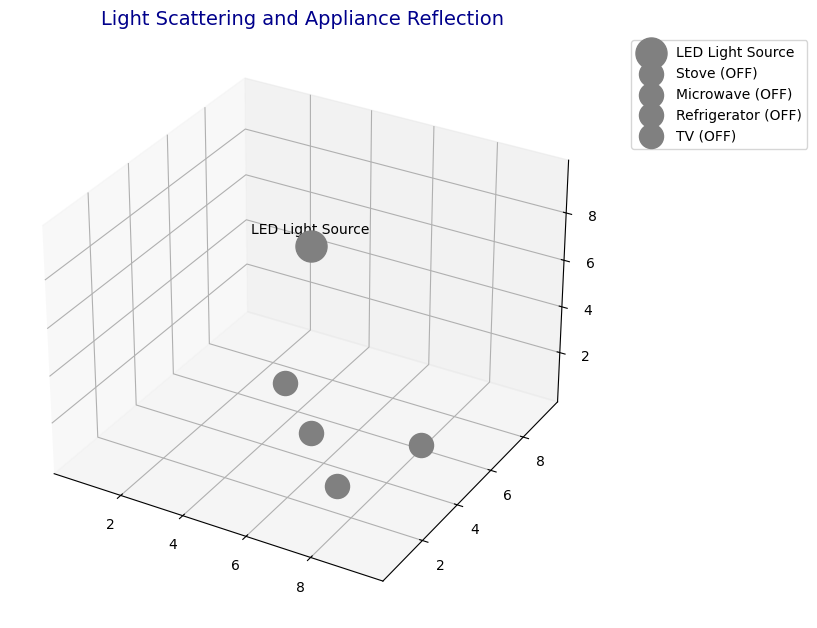

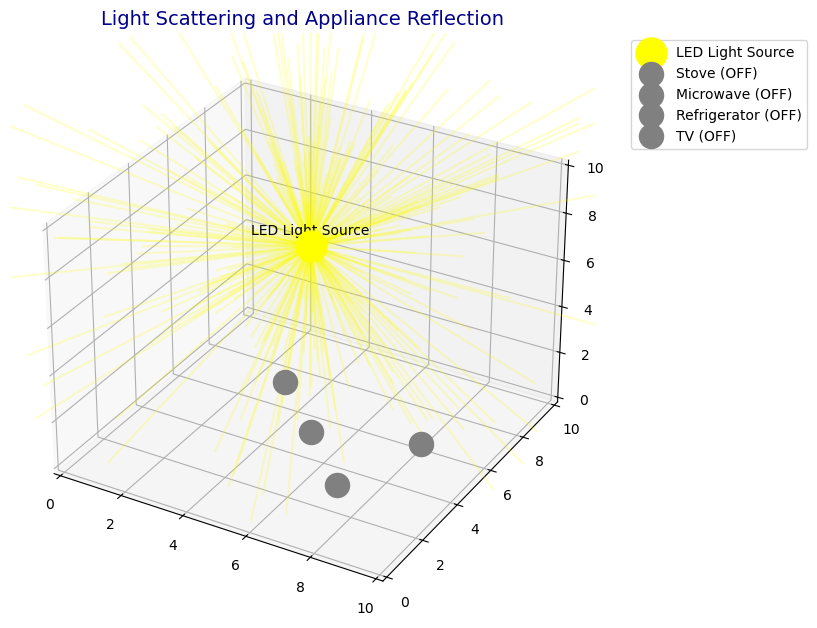

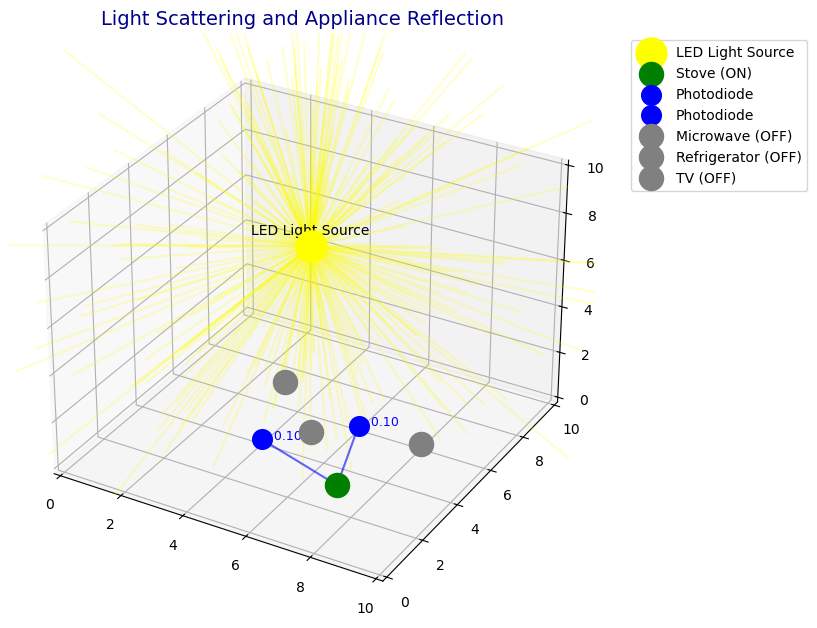

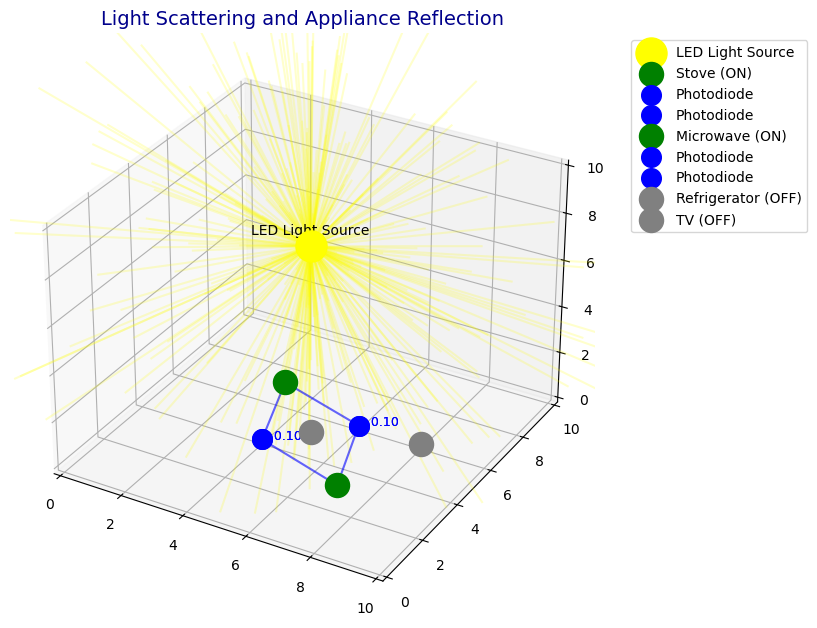

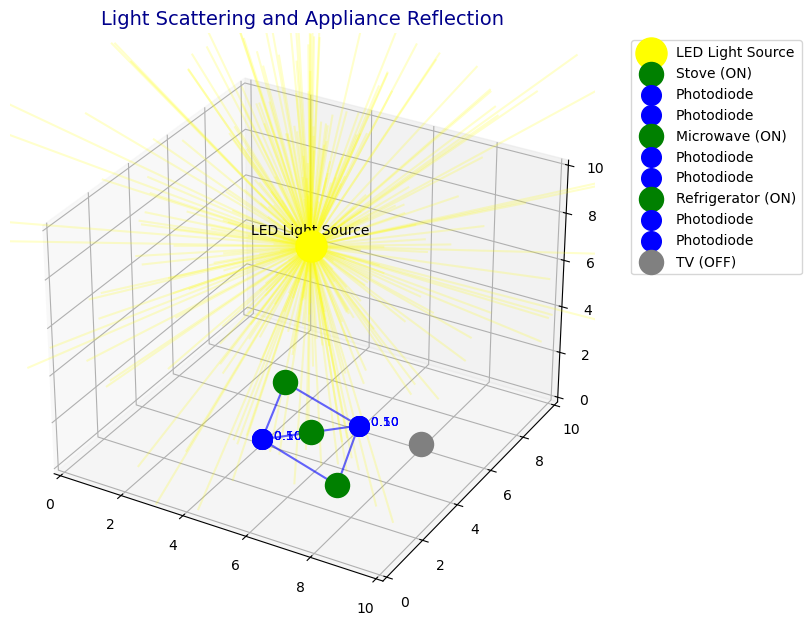

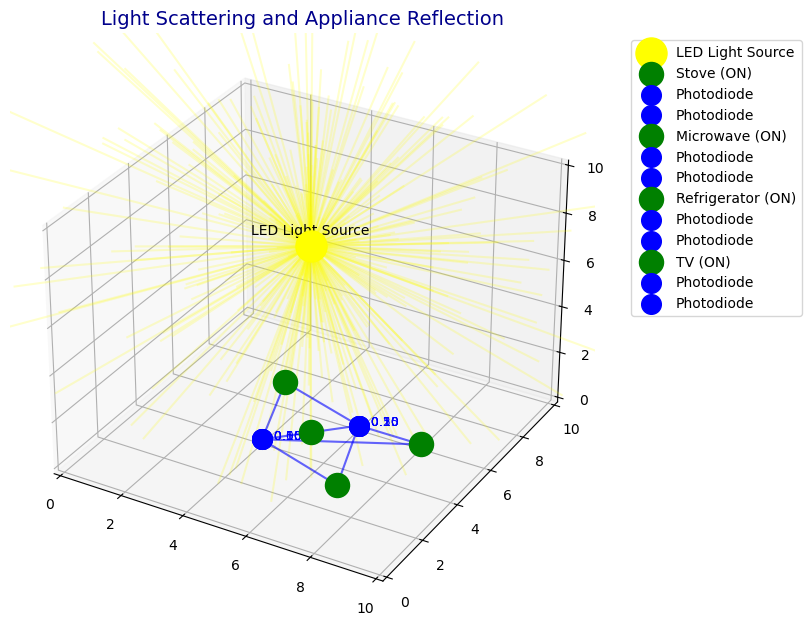

In [15]:
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import numpy as np
import random

# Appliance attributes based on reference images
appliances = {
    "Stove": {"position": (7, 3, 0), "attributes": "Flame Intensity: 85, Temperature: 300°C, Smoke: None"},
    "Microwave": {"position": (3, 7, 0), "attributes": "Power: 1200W, Temperature: 80°C, Radiation: 0.4 mW/cm²"},
    "Refrigerator": {"position": (5, 5, 0), "attributes": "Temperature: 5°C, Humidity: 75%, Energy Usage: 150W"},
    "TV": {"position": (8, 6, 0), "attributes": "Brightness: 200 Lux, Temperature: 35°C, Usage Time: 2 hrs"}
}

# Photodiode positions
photodiodes = [(4, 4, 0), (6, 6, 0)]
light_on = False  # LED light status
appliance_status = {name: False for name in appliances.keys()}  # Appliance toggle states
photodiode_data = {}

# Function to simulate light scattering
def simulate_light_scattering(ax, frames):
    global photodiode_data
    ax.clear()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_zlim(0, 10)
    ax.set_title("Light Scattering and Appliance Reflection", fontsize=14, color="darkblue")

    # LED bulb symbol
    led_color = "yellow" if light_on else "gray"
    ax.scatter(5, 5, 8, color=led_color, s=500, label="LED Light Source")
    ax.text(5, 5, 8.5, "LED Light Source", fontsize=10, color="black", ha="center")

    if light_on:
        # Animate light rays emanating from the LED bulb
        for _ in range(300):
            theta = random.uniform(0, 2 * np.pi)
            phi = random.uniform(0, np.pi)
            distance = random.uniform(1, 10)
            x = 5 + distance * np.cos(theta) * np.sin(phi)
            y = 5 + distance * np.sin(theta) * np.sin(phi)
            z = 8 + distance * np.cos(phi)
            ax.plot([5, x], [5, y], [8, z], color="yellow", alpha=0.2)

    # Appliance reflection and interactions
    photodiode_data = {pd: [] for pd in photodiodes}
    for appliance, data in appliances.items():
        status = appliance_status[appliance]
        color = "green" if status else "gray"
        ax.scatter(*data["position"], color=color, s=300, label=f"{appliance} ({'ON' if status else 'OFF'})")

        if light_on and status:
            for pd in photodiodes:
                # Calculate reflection from appliance to photodiode
                distance = np.linalg.norm(np.array(data["position"]) - np.array(pd))
                intensity = round(1 / (distance**2), 2)
                photodiode_data[pd].append({"appliance": appliance, "intensity": intensity, "attributes": data["attributes"]})

                # Animate reflection rays
                ax.plot(
                    [data["position"][0], pd[0]],
                    [data["position"][1], pd[1]],
                    [data["position"][2], pd[2]],
                    color="blue",
                    alpha=0.6
                )
                ax.scatter(*pd, color="blue", s=200, label="Photodiode")
                ax.text(*pd, f"I: {intensity:.2f}", color="blue", fontsize=9)

    ax.legend(
        fontsize=10,
        loc="upper left",
        bbox_to_anchor=(1.05, 1)
    )

# Function to update GUI plot
def update_plot():
    global canvas, ani
    fig = plt.figure(figsize=(10, 6))  # Increase figure size for better visibility
    ax = fig.add_subplot(111, projection="3d")
    ani = FuncAnimation(fig, lambda frame: simulate_light_scattering(ax, frame), frames=50, interval=100)
    canvas.get_tk_widget().destroy()
    canvas = FigureCanvasTkAgg(fig, master=frame_visualization)
    canvas.draw()
    canvas.get_tk_widget().pack(fill="both", expand=True)

# Toggle LED light
def toggle_light():
    global light_on
    light_on = not light_on
    update_plot()

# Toggle appliance state
def toggle_appliance(appliance):
    global appliance_status
    appliance_status[appliance] = not appliance_status[appliance]
    update_plot()

# Show high-intensity beams
def show_high_intensity():
    analysis_window = tk.Toplevel(root)
    analysis_window.title("High-Intensity Beam Analysis")
    tk.Label(analysis_window, text="High-Intensity Beam Analysis", font=("Arial", 16, "bold")).pack(pady=10)
    for pd, data_list in photodiode_data.items():
        if data_list:
            highest_intensity = max(data_list, key=lambda x: x["intensity"])
            tk.Label(
                analysis_window,
                text=f"Photodiode at {pd}:\n"
                     f"  Detected Appliance: {highest_intensity['appliance']}\n"
                     f"  Intensity: {highest_intensity['intensity']}\n"
                     f"  Attributes: {highest_intensity['attributes']}",
                font=("Arial", 12),
                justify="left",
                bg="lightyellow",
                padx=10,
                pady=5
            ).pack(pady=5, fill="both", expand=True)

# Show all intensities
def show_all_intensities():
    analysis_window = tk.Toplevel(root)
    analysis_window.title("All Intensities Analysis")
    tk.Label(analysis_window, text="All Intensities Analysis", font=("Arial", 16, "bold")).pack(pady=10)
    for pd, data_list in photodiode_data.items():
        tk.Label(
            analysis_window,
            text=f"Photodiode at {pd}:",
            font=("Arial", 14),
            bg="lightblue",
            padx=10,
            pady=5,
            anchor="w"
        ).pack(fill="both", expand=True, pady=5)
        for data in data_list:
            tk.Label(
                analysis_window,
                text=f"  Detected Appliance: {data['appliance']}\n"
                     f"  Intensity: {data['intensity']}\n"
                     f"  Attributes: {data['attributes']}",
                font=("Arial", 12),
                justify="left",
                bg="lightyellow",
                padx=10,
                pady=5
            ).pack(pady=5, fill="both", expand=True)

# Main application GUI
root = tk.Tk()
root.title("VLC Room Simulation")
root.geometry("1400x800")  # Increased width for better visualization

# Main layout frame
frame_main = tk.Frame(root)
frame_main.pack(fill="both", expand=True, padx=10, pady=10)

# Controls frame (left side)
frame_controls = tk.Frame(frame_main, width=400, bg="lightgray")
frame_controls.pack(side="left", fill="y", padx=10, pady=10)

tk.Label(frame_controls, text="Controls", font=("Arial", 16, "bold"), bg="lightgray").pack(pady=20)
btn_light = tk.Button(frame_controls, text="Toggle LED Light", command=toggle_light, bg="yellow", font=("Arial", 12))
btn_light.pack(pady=10)

for appliance in appliances.keys():
    btn_appliance = tk.Button(
        frame_controls,
        text=f"Toggle {appliance}",
        command=lambda a=appliance: toggle_appliance(a),
        bg="lightgreen",
        font=("Arial", 12)
    )
    btn_appliance.pack(pady=5)

btn_high_intensity = tk.Button(frame_controls, text="Show High-Intensity Beam", command=show_high_intensity, bg="orange", font=("Arial", 12))
btn_high_intensity.pack(pady=10)

btn_all_intensities = tk.Button(frame_controls, text="Show All Intensities", command=show_all_intensities, bg="blue", fg="white", font=("Arial", 12))
btn_all_intensities.pack(pady=10)

# Visualization frame (right side)
frame_visualization = tk.Frame(frame_main, bg="white")
frame_visualization.pack(side="right", fill="both", expand=True, padx=10, pady=10)

canvas = FigureCanvasTkAgg(plt.figure(), master=frame_visualization)
canvas.get_tk_widget().pack(fill="both", expand=True)

# Run application
update_plot()
root.mainloop()